# Preparing the Visual WetlandBirds Dataset for the Hub

In this notebook, we will prepare the Visual WetlandBirds Dataset for sharing on the Hub. The original dataset can be found on Zenodo: [https://zenodo.org/records/14639444](https://zenodo.org/records/14639444).

## What this notebook will help you learn

This notebook will help you learn:

- How to prepare a video dataset for the Hub using the `VideoFolder` dataset format.
- Give you some tips for working with the resulting dataset on the Hub.

## The dataset

The dataset consists of videos + various metadata files.

![](https://huggingface.co/datasets/davanstrien/images/resolve/main/zenodo-folder-structure.png)

The part we're most interested in is the `bounding_boxes.csv` file, which contains the bounding boxes for frames from each video which have been annotated with a bird species and behavior.


### Preparing the dataset for the Hub

Let's first start by briefly understanding how the `Video` feature in datasets works. We'll start by creating a simple dataset with a single video from the `videos` folder.



In [ ]:
from datasets import Dataset, Video

ds = Dataset.from_dict({"video": ["dataset/videos/001-white_wagtail.mp4"]}).cast_column(
    "video", Video()
)

Let's see what the dataset looks like:


In [ ]:
ds

We can also index into a row and grab the video:

In [ ]:
print(type(ds[0]["video"]))

We can see that under the hood, the `Video` feature is uning `torchvision.io.VideoReader` to read the video.

Let's now see how can load our full dataset. If we just need to load videos, we can use the `VideoFolder` loader to load the videos.

In [ ]:
from datasets import load_dataset

In [ ]:
ds = load_dataset("videofolder", data_dir="dataset/videos")

but since we also have annotations, we'll need to load the annotations as well. There are a few ways we could do this but a fairly simple way is to just ensure that we have a `metadata.jsonl` file formated in a way that `VideoFolder` can understand. Let's take a look at the `metadata.csv` file:


In [ ]:
import polars as pl

In [ ]:
df = pl.read_csv("bounding_boxes.csv", separator=";")

In [ ]:
print(df)

We can see how many annotations we have per video:

In [ ]:
print(df.group_by("video_name").agg(pl.len()))

We also have a few other files, some of these duplicate information so we can ignore them but `behaviors_ID.csv` contains a mapping of behavior IDs to behavior names which will be useful for us. We can convert this to a dictionary for easy lookups later.


In [ ]:
import polars as pl

behavior_mapping = {}

for row in pl.read_csv("behaviors_ID.csv").iter_rows():
    behavior_mapping[row[1]] = row[0]

In [ ]:
behavior_mapping

### Vibe code the JSONL file

Now we just need to conver the rest of the metadata to a format that `VideoFolder` can understand. We'll do this by creating a JSONL file that contains the bounding box annotations for each frame.

While it's not particularly difficult to write this code, for this part I just gave an LLM a sample of the CSV and told it what kind of output I wanted and it came up with something that worked fine. Since this is a one-time operation, I don't really care about the code quality much anyway.

In [ ]:
import pandas as pd
import json
from pathlib import Path
import ast


def convert_to_jsonl():
    # Read the CSV file
    df = pd.read_csv("bounding_boxes.csv", sep=";")

    # Create output directory if it doesn't exist
    output_dir = Path("annotations")
    output_dir.mkdir(exist_ok=True)

    # Create JSONL file
    with open(output_dir / "metadata.jsonl", "w") as f:
        for idx, row in df.iterrows():
            try:
                # Parse the bounding box string
                bbox_str = row["bounding_boxes"].strip("[]")
                if bbox_str:
                    # Use ast.literal_eval for safer evaluation
                    bbox_list = ast.literal_eval(f"[{bbox_str}]")
                    if isinstance(bbox_list, list) and len(bbox_list) > 0:
                        bbox = bbox_list[0]
                        if isinstance(bbox, (list, tuple)) and len(bbox) == 6:
                            # Create flattened annotation entry
                            annotation = {
                                "file_name": f"{row['video_name']}.mp4",
                                "frame": int(row["frame"]),
                                "x_max": float(bbox[0]),
                                "y_max": float(bbox[1]),
                                "x_min": float(bbox[2]),
                                "y_min": float(bbox[3]),
                                "behavior_id": int(bbox[4]),
                                "behavior": behavior_mapping.get(
                                    int(bbox[4]), "unknown"
                                ),
                                "bird_id": int(bbox[5]),
                                "species_id": int(row["species_id"]),
                                "species": row["species"],
                            }

                            # Write to JSONL file
                            f.write(json.dumps(annotation) + "\n")
                        else:
                            print(f"Warning: Invalid bounding box format in row {idx}")
                            print(f"Video: {row['video_name']}, Frame: {row['frame']}")
                            print(f"Bounding box: {bbox}")
                    else:
                        print(f"Warning: Invalid bounding box list in row {idx}")
                        print(f"Video: {row['video_name']}, Frame: {row['frame']}")
                        print(f"Bounding box list: {bbox_list}")
            except Exception as e:
                print(f"Error processing row {idx}:")
                print(f"Video: {row['video_name']}, Frame: {row['frame']}")
                print(f"Error: {str(e)}")
                print(f"Row data: {row.to_dict()}")
                continue


convert_to_jsonl()

We now have a `metadata.jsonl` file that we can use to load the annotations. Let's load the videos and annotations together using the `VideoFolder` loader.


In [ ]:
!head -n 2 annotations/metadata.jsonl

The only thing we need to do is to move this file to be in the same directory as the videos (I just did this manually). Now we can load the dataset using the `VideoFolder` loader, it will automatically load the annotations.



In [ ]:
dataset = load_dataset("videofolder", data_dir="dataset/videos")

Let's take a look at the first row:

In [ ]:
dataset["train"][3]

We can see that we have the video, alongside the other annotations. We could modify how the bounding boxes are defined but this is quite close to what we had in the CSV file and can be easily modified later if needed.


### Uploading to the Hub

Now that we have the dataset in the correct format, we can upload it to the Hub. Since we have a fairly large dataset, we'll need to use the `upload_large_folder` function. You'll need to be logged in to the Hub to do the upload and have the necessary permissions. Otherwise we can just provide

- folder_path: the path to the folder containing the videos and annotations
- repo_id: the repository id to upload to
- repo_type: the repository type, in this case `dataset`

In [ ]:
from huggingface_hub import HfApi

api = HfApi()

api.upload_large_folder(
    folder_path="dataset",
    repo_id="academic-datasets/Visual-WetlandBirds-Dataset",
    repo_type="dataset",
)

## Loading the dataset from the Hub


In [1]:
%pip install datasets torchvision av

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [2]:
from datasets import load_dataset

ds = load_dataset("academic-datasets/Visual-WetlandBirds-Dataset")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


Resolving data files:   0%|          | 0/179 [00:00<?, ?it/s]

001-white_wagtail.mp4:   0%|          | 0.00/98.0M [00:00<?, ?B/s]

002-squacco_heron.mp4:   0%|          | 0.00/12.5M [00:00<?, ?B/s]

003-squacco_heron.mp4:   0%|          | 0.00/13.0M [00:00<?, ?B/s]

004-squacco_heron.mp4:   0%|          | 0.00/4.23M [00:00<?, ?B/s]

005-squacco_heron.mp4:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

006-yellow_legged_gull.mp4:   0%|          | 0.00/17.0M [00:00<?, ?B/s]

007-yellow_legged_gull.mp4:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

008-yellow_legged_gull.mp4:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

009-yellow_legged_gull.mp4:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

010-yellow_legged_gull.mp4:   0%|          | 0.00/64.9M [00:00<?, ?B/s]

011-yellow_legged_gull.mp4:   0%|          | 0.00/23.5M [00:00<?, ?B/s]

012-black_headed_gull.mp4:   0%|          | 0.00/17.0M [00:00<?, ?B/s]

013-black_headed_gull.mp4:   0%|          | 0.00/152M [00:00<?, ?B/s]

014-black_headed_gull.mp4:   0%|          | 0.00/138M [00:00<?, ?B/s]

015-black_headed_gull.mp4:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

016-black_headed_gull.mp4:   0%|          | 0.00/17.4M [00:00<?, ?B/s]

017-black_headed_gull.mp4:   0%|          | 0.00/26.5M [00:00<?, ?B/s]

018-eurasian_coot.mp4:   0%|          | 0.00/84.2M [00:00<?, ?B/s]

019-eurasian_coot.mp4:   0%|          | 0.00/14.0M [00:00<?, ?B/s]

020-eurasian_coot.mp4:   0%|          | 0.00/79.3M [00:00<?, ?B/s]

021-little_ringed_plover.mp4:   0%|          | 0.00/9.18M [00:00<?, ?B/s]

022-little_ringed_plover.mp4:   0%|          | 0.00/20.2M [00:00<?, ?B/s]

023-glossy_ibis.mp4:   0%|          | 0.00/74.9M [00:00<?, ?B/s]

024-black_headed_gull.mp4:   0%|          | 0.00/213M [00:00<?, ?B/s]

025-black_headed_gull.mp4:   0%|          | 0.00/17.0M [00:00<?, ?B/s]

026-black_headed_gull.mp4:   0%|          | 0.00/44.5M [00:00<?, ?B/s]

027-gadwall.mp4:   0%|          | 0.00/86.5M [00:00<?, ?B/s]

028-gadwall.mp4:   0%|          | 0.00/111M [00:00<?, ?B/s]

029-gadwall.mp4:   0%|          | 0.00/101M [00:00<?, ?B/s]

030-gadwall.mp4:   0%|          | 0.00/55.2M [00:00<?, ?B/s]

031-gadwall.mp4:   0%|          | 0.00/67.4M [00:00<?, ?B/s]

032-gadwall.mp4:   0%|          | 0.00/112M [00:00<?, ?B/s]

033-gadwall.mp4:   0%|          | 0.00/106M [00:00<?, ?B/s]

034-gadwall.mp4:   0%|          | 0.00/113M [00:00<?, ?B/s]

035-gadwall.mp4:   0%|          | 0.00/44.4M [00:00<?, ?B/s]

036-gadwall.mp4:   0%|          | 0.00/113M [00:00<?, ?B/s]

037-gadwall.mp4:   0%|          | 0.00/155M [00:00<?, ?B/s]

038-gadwall.mp4:   0%|          | 0.00/91.5M [00:00<?, ?B/s]

039-gadwall.mp4:   0%|          | 0.00/70.8M [00:00<?, ?B/s]

040-mallard.mp4:   0%|          | 0.00/150M [00:00<?, ?B/s]

041-mallard.mp4:   0%|          | 0.00/74.3M [00:00<?, ?B/s]

042-mallard.mp4:   0%|          | 0.00/141M [00:00<?, ?B/s]

043-mallard.mp4:   0%|          | 0.00/97.7M [00:00<?, ?B/s]

044-mallard.mp4:   0%|          | 0.00/102M [00:00<?, ?B/s]

045-mallard.mp4:   0%|          | 0.00/82.3M [00:00<?, ?B/s]

046-mallard.mp4:   0%|          | 0.00/226M [00:00<?, ?B/s]

047-glossy_ibis.mp4:   0%|          | 0.00/29.6M [00:00<?, ?B/s]

048-glossy_ibis.mp4:   0%|          | 0.00/7.90M [00:00<?, ?B/s]

049-glossy_ibis.mp4:   0%|          | 0.00/35.2M [00:00<?, ?B/s]

050-eurasian_moorhen.mp4:   0%|          | 0.00/27.1M [00:00<?, ?B/s]

051-eurasian_moorhen.mp4:   0%|          | 0.00/153M [00:00<?, ?B/s]

052-eurasian_moorhen.mp4:   0%|          | 0.00/9.06M [00:00<?, ?B/s]

053-eurasian_moorhen.mp4:   0%|          | 0.00/24.2M [00:00<?, ?B/s]

054-eurasian_moorhen.mp4:   0%|          | 0.00/20.6M [00:00<?, ?B/s]

055-eurasian_moorhen.mp4:   0%|          | 0.00/90.2M [00:00<?, ?B/s]

056-eurasian_moorhen.mp4:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

057-eurasian_moorhen.mp4:   0%|          | 0.00/39.2M [00:00<?, ?B/s]

058-northern_shoveler.mp4:   0%|          | 0.00/137M [00:00<?, ?B/s]

059-northern_shoveler.mp4:   0%|          | 0.00/154M [00:00<?, ?B/s]

060-northern_shoveler.mp4:   0%|          | 0.00/36.2M [00:00<?, ?B/s]

061-northern_shoveler.mp4:   0%|          | 0.00/107M [00:00<?, ?B/s]

062-northern_shoveler.mp4:   0%|          | 0.00/92.0M [00:00<?, ?B/s]

063-northern_shoveler.mp4:   0%|          | 0.00/88.6M [00:00<?, ?B/s]

064-northern_shoveler.mp4:   0%|          | 0.00/138M [00:00<?, ?B/s]

065-northern_shoveler.mp4:   0%|          | 0.00/96.2M [00:00<?, ?B/s]

066-northern_shoveler.mp4:   0%|          | 0.00/156M [00:00<?, ?B/s]

067-northern_shoveler.mp4:   0%|          | 0.00/99.0M [00:00<?, ?B/s]

068-northern_shoveler.mp4:   0%|          | 0.00/189M [00:00<?, ?B/s]

069-northern_shoveler.mp4:   0%|          | 0.00/79.2M [00:00<?, ?B/s]

070-northern_shoveler.mp4:   0%|          | 0.00/75.8M [00:00<?, ?B/s]

071-black_winged_stilt.mp4:   0%|          | 0.00/87.6M [00:00<?, ?B/s]

072-black_winged_stilt.mp4:   0%|          | 0.00/70.7M [00:00<?, ?B/s]

073-black_winged_stilt.mp4:   0%|          | 0.00/76.7M [00:00<?, ?B/s]

074-black_winged_stilt.mp4:   0%|          | 0.00/97.6M [00:00<?, ?B/s]

075-black_winged_stilt.mp4:   0%|          | 0.00/112M [00:00<?, ?B/s]

076-black_winged_stilt.mp4:   0%|          | 0.00/89.1M [00:00<?, ?B/s]

077-black_winged_stilt.mp4:   0%|          | 0.00/50.7M [00:00<?, ?B/s]

078-eurasian_magpie.mp4:   0%|          | 0.00/33.8M [00:00<?, ?B/s]

079-eurasian_magpie.mp4:   0%|          | 0.00/28.2M [00:00<?, ?B/s]

080-yellow_legged_gull.mp4:   0%|          | 0.00/25.5M [00:00<?, ?B/s]

081-yellow_legged_gull.mp4:   0%|          | 0.00/26.5M [00:00<?, ?B/s]

082-yellow_legged_gull.mp4:   0%|          | 0.00/206M [00:00<?, ?B/s]

083-yellow_legged_gull.mp4:   0%|          | 0.00/26.5M [00:00<?, ?B/s]

084-yellow_legged_gull.mp4:   0%|          | 0.00/33.3M [00:00<?, ?B/s]

085-yellow_legged_gull.mp4:   0%|          | 0.00/7.70M [00:00<?, ?B/s]

086-little_ringed_plover.mp4:   0%|          | 0.00/6.53M [00:00<?, ?B/s]

087-little_ringed_plover.mp4:   0%|          | 0.00/3.72M [00:00<?, ?B/s]

088-little_ringed_plover.mp4:   0%|          | 0.00/3.00M [00:00<?, ?B/s]

089-little_ringed_plover.mp4:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

090-little_ringed_plover.mp4:   0%|          | 0.00/7.21M [00:00<?, ?B/s]

091-little_ringed_plover.mp4:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

092-little_ringed_plover.mp4:   0%|          | 0.00/3.01M [00:00<?, ?B/s]

093-little_ringed_plover.mp4:   0%|          | 0.00/6.97M [00:00<?, ?B/s]

094-white_wagtail.mp4:   0%|          | 0.00/160M [00:00<?, ?B/s]

095-white_wagtail.mp4:   0%|          | 0.00/117M [00:00<?, ?B/s]

096-white_wagtail.mp4:   0%|          | 0.00/11.1M [00:00<?, ?B/s]

097-white_wagtail.mp4:   0%|          | 0.00/82.3M [00:00<?, ?B/s]

098-white_wagtail.mp4:   0%|          | 0.00/75.6M [00:00<?, ?B/s]

099-white_wagtail.mp4:   0%|          | 0.00/89.3M [00:00<?, ?B/s]

100-eurasian_coot.mp4:   0%|          | 0.00/131M [00:00<?, ?B/s]

101-eurasian_coot.mp4:   0%|          | 0.00/86.3M [00:00<?, ?B/s]

102-eurasian_coot.mp4:   0%|          | 0.00/77.8M [00:00<?, ?B/s]

103-eurasian_coot.mp4:   0%|          | 0.00/66.3M [00:00<?, ?B/s]

104-eurasian_coot.mp4:   0%|          | 0.00/113M [00:00<?, ?B/s]

105-eurasian_coot.mp4:   0%|          | 0.00/125M [00:00<?, ?B/s]

106-eurasian_coot.mp4:   0%|          | 0.00/70.2M [00:00<?, ?B/s]

107-eurasian_coot.mp4:   0%|          | 0.00/126M [00:00<?, ?B/s]

108-eurasian_coot.mp4:   0%|          | 0.00/78.1M [00:00<?, ?B/s]

109-eurasian_coot.mp4:   0%|          | 0.00/124M [00:00<?, ?B/s]

110-eurasian_coot.mp4:   0%|          | 0.00/33.8M [00:00<?, ?B/s]

111-eurasian_coot.mp4:   0%|          | 0.00/23.9M [00:00<?, ?B/s]

112-eurasian_coot.mp4:   0%|          | 0.00/139M [00:00<?, ?B/s]

113-eurasian_moorhen.mp4:   0%|          | 0.00/20.0M [00:00<?, ?B/s]

114-eurasian_moorhen.mp4:   0%|          | 0.00/22.3M [00:00<?, ?B/s]

115-eurasian_moorhen.mp4:   0%|          | 0.00/13.4M [00:00<?, ?B/s]

116-eurasian_moorhen.mp4:   0%|          | 0.00/25.7M [00:00<?, ?B/s]

117-eurasian_moorhen.mp4:   0%|          | 0.00/11.0M [00:00<?, ?B/s]

118-eurasian_moorhen.mp4:   0%|          | 0.00/11.0M [00:00<?, ?B/s]

119-eurasian_moorhen.mp4:   0%|          | 0.00/11.3M [00:00<?, ?B/s]

120-eurasian_moorhen.mp4:   0%|          | 0.00/16.8M [00:00<?, ?B/s]

121-eurasian_moorhen.mp4:   0%|          | 0.00/13.2M [00:00<?, ?B/s]

122-black_headed_gull.mp4:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

123-black_headed_gull.mp4:   0%|          | 0.00/3.68M [00:00<?, ?B/s]

124-black_headed_gull.mp4:   0%|          | 0.00/9.83M [00:00<?, ?B/s]

125-eurasian_magpie.mp4:   0%|          | 0.00/5.28M [00:00<?, ?B/s]

126-eurasian_magpie.mp4:   0%|          | 0.00/5.47M [00:00<?, ?B/s]

127-eurasian_magpie.mp4:   0%|          | 0.00/13.8M [00:00<?, ?B/s]

128-eurasian_moorhen.mp4:   0%|          | 0.00/12.5M [00:00<?, ?B/s]

129-eurasian_magpie.mp4:   0%|          | 0.00/13.0M [00:00<?, ?B/s]

130-eurasian_magpie.mp4:   0%|          | 0.00/5.29M [00:00<?, ?B/s]

131-eurasian_magpie.mp4:   0%|          | 0.00/13.8M [00:00<?, ?B/s]

132-eurasian_magpie.mp4:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

133-eurasian_magpie.mp4:   0%|          | 0.00/4.30M [00:00<?, ?B/s]

134-eurasian_magpie.mp4:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

135-eurasian_magpie.mp4:   0%|          | 0.00/4.72M [00:00<?, ?B/s]

136-eurasian_magpie.mp4:   0%|          | 0.00/5.80M [00:00<?, ?B/s]

137-eurasian_magpie.mp4:   0%|          | 0.00/17.0M [00:00<?, ?B/s]

138-eurasian_magpie.mp4:   0%|          | 0.00/4.45M [00:00<?, ?B/s]

139-eurasian_coot.mp4:   0%|          | 0.00/145M [00:00<?, ?B/s]

140-mallard.mp4:   0%|          | 0.00/29.9M [00:00<?, ?B/s]

141-mallard.mp4:   0%|          | 0.00/24.6M [00:00<?, ?B/s]

142-mallard.mp4:   0%|          | 0.00/14.4M [00:00<?, ?B/s]

143-squacco_heron.mp4:   0%|          | 0.00/14.1M [00:00<?, ?B/s]

144-squacco_heron.mp4:   0%|          | 0.00/11.6M [00:00<?, ?B/s]

145-squacco_heron.mp4:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

146-squacco_heron.mp4:   0%|          | 0.00/14.1M [00:00<?, ?B/s]

147-squacco_heron.mp4:   0%|          | 0.00/9.89M [00:00<?, ?B/s]

148-squacco_heron.mp4:   0%|          | 0.00/11.7M [00:00<?, ?B/s]

149-squacco_heron.mp4:   0%|          | 0.00/13.9M [00:00<?, ?B/s]

150-squacco_heron.mp4:   0%|          | 0.00/13.8M [00:00<?, ?B/s]

151-squacco_heron.mp4:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

152-squacco_heron.mp4:   0%|          | 0.00/12.1M [00:00<?, ?B/s]

153-squacco_heron.mp4:   0%|          | 0.00/10.6M [00:00<?, ?B/s]

154-northern_shoveler.mp4:   0%|          | 0.00/131M [00:00<?, ?B/s]

155-black_winged_stilt.mp4:   0%|          | 0.00/11.5M [00:00<?, ?B/s]

156-black_winged_stilt.mp4:   0%|          | 0.00/8.80M [00:00<?, ?B/s]

157-black_winged_stilt.mp4:   0%|          | 0.00/24.7M [00:00<?, ?B/s]

158-black_winged_stilt.mp4:   0%|          | 0.00/25.3M [00:00<?, ?B/s]

159-yellow_legged_gull.mp4:   0%|          | 0.00/111M [00:00<?, ?B/s]

160-glossy_ibis.mp4:   0%|          | 0.00/14.4M [00:00<?, ?B/s]

161-glossy_ibis.mp4:   0%|          | 0.00/12.8M [00:00<?, ?B/s]

162-glossy_ibis.mp4:   0%|          | 0.00/12.7M [00:00<?, ?B/s]

163-white_wagtail.mp4:   0%|          | 0.00/7.48M [00:00<?, ?B/s]

164-white_wagtail.mp4:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

165-glossy_ibis.mp4:   0%|          | 0.00/11.9M [00:00<?, ?B/s]

166-white_wagtail.mp4:   0%|          | 0.00/7.80M [00:00<?, ?B/s]

167-white_wagtail.mp4:   0%|          | 0.00/85.1M [00:00<?, ?B/s]

168-white_wagtail.mp4:   0%|          | 0.00/13.9M [00:00<?, ?B/s]

169-black_winged_stilt.mp4:   0%|          | 0.00/19.7M [00:00<?, ?B/s]

170-black_winged_stilt.mp4:   0%|          | 0.00/11.2M [00:00<?, ?B/s]

171-black_winged_stilt.mp4:   0%|          | 0.00/96.6M [00:00<?, ?B/s]

172-black_headed_gull.mp4:   0%|          | 0.00/7.91M [00:00<?, ?B/s]

173-black_headed_gull.mp4:   0%|          | 0.00/7.94M [00:00<?, ?B/s]

174-eurasian_coot.mp4:   0%|          | 0.00/107M [00:00<?, ?B/s]

175-eurasian_coot.mp4:   0%|          | 0.00/19.2M [00:00<?, ?B/s]

176-black_headed_gull.mp4:   0%|          | 0.00/14.1M [00:00<?, ?B/s]

177-eurasian_magpie.mp4:   0%|          | 0.00/4.03M [00:00<?, ?B/s]

178-white_wagtail.mp4:   0%|          | 0.00/15.2M [00:00<?, ?B/s]

metadata.jsonl:   0%|          | 0.00/26.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120694 [00:00<?, ? examples/s]

In [3]:
ds["train"][0]

{'video': <torchvision.io.video_reader.VideoReader at 0x7d5648b059d0>,
 'frame': 0,
 'x_max': 364.62,
 'y_max': 191.11,
 'x_min': 574.08,
 'y_min': 394.75,
 'behavior_id': 1,
 'behavior': 'Preening',
 'bird_id': 0,
 'species_id': 0,
 'species': 'White Wagtail'}

In [4]:
video = ds["train"][0]["video"]
first_frame = next(video)

In [5]:
first_frame

{'data': tensor([[[134, 139, 151,  ..., 146, 149, 154],
          [160, 151, 155,  ..., 156, 151, 153],
          [186, 173, 170,  ..., 147, 149, 142],
          ...,
          [159, 158, 160,  ..., 152, 153, 153],
          [162, 161, 161,  ..., 157, 156, 161],
          [164, 163, 162,  ..., 162, 161, 161]],
 
         [[100, 105, 117,  ..., 114, 117, 122],
          [126, 117, 121,  ..., 124, 119, 121],
          [152, 139, 136,  ..., 115, 117, 110],
          ...,
          [129, 128, 130,  ..., 123, 124, 124],
          [129, 128, 128,  ..., 125, 124, 129],
          [131, 130, 129,  ..., 130, 129, 129]],
 
         [[ 68,  73,  85,  ...,  82,  85,  90],
          [ 94,  85,  89,  ...,  92,  87,  89],
          [120, 107, 104,  ...,  83,  85,  78],
          ...,
          [101, 100, 104,  ...,  92,  93,  93],
          [102, 101, 103,  ...,  95,  94,  99],
          [104, 103, 104,  ..., 100,  99,  99]]], dtype=torch.uint8),
 'pts': 0.0}

In [6]:
print(first_frame["data"].shape)
print(first_frame["pts"])  # timestamp

torch.Size([3, 540, 960])
0.0


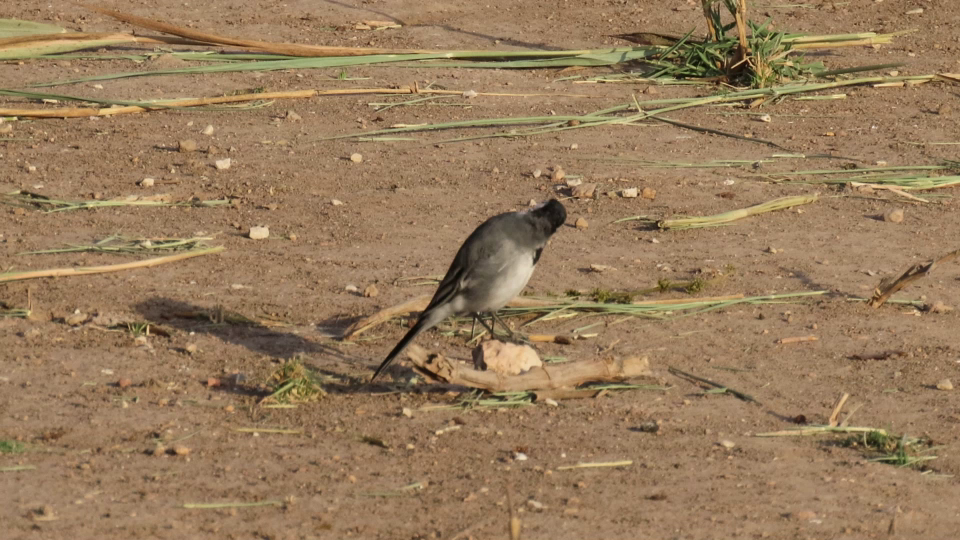

In [7]:
from torchvision.transforms.functional import to_pil_image

to_pil_image(first_frame["data"])

Some more vibe coded

In [8]:
def get_frame_by_index(reader, frame_index):
    # Get the fps to calculate the timestamp
    metadata = reader.get_metadata()
    fps = metadata["video"]["fps"][0]  # Extract from list

    # Convert frame index to timestamp
    timestamp = frame_index / fps

    # Seek to that timestamp
    reader.seek(timestamp)

    # Get the frame
    frame = next(reader)
    return frame["data"]  # This returns just the tensor data

/usr/local/lib/python3.11/dist-packages/torchvision/io/video_reader.py:241: UserWarning: Accurate seek is not implemented for pyav backend
  warnings.warn("Accurate seek is not implemented for pyav backend")


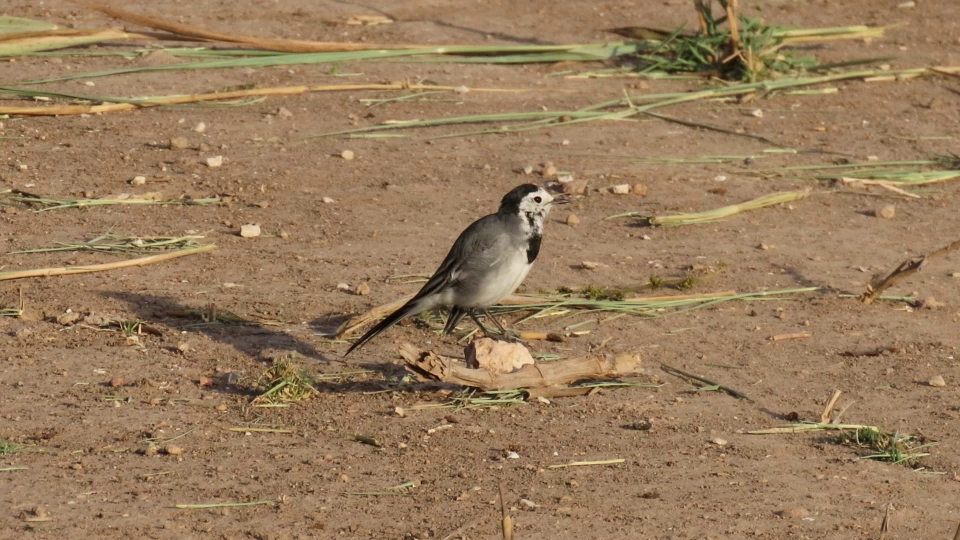

In [9]:
to_pil_image(get_frame_by_index(video, 50))

In [10]:
import torch
import torchvision
from torchvision.io import VideoReader
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw


def get_frame_with_bbox(example):
    """
    Extract a frame from the video and draw the bounding box on it

    Parameters:
    example: A dictionary containing video, frame index, and bounding box coordinates

    Returns:
    PIL Image with the bounding box drawn on it
    """
    # Get the video reader
    video_reader = example["video"]

    # Get metadata to extract fps
    metadata = video_reader.get_metadata()
    fps = metadata["video"]["fps"][0]  # Extract fps from list

    # Calculate timestamp from frame index
    frame_index = example["frame"]
    timestamp = frame_index / fps

    # Seek to the timestamp
    video_reader.seek(timestamp)

    # Get the frame
    frame = next(video_reader)
    frame_tensor = frame["data"]

    # Convert to PIL image for drawing
    pil_image = to_pil_image(frame_tensor)

    # Create a drawing object
    draw = ImageDraw.Draw(pil_image)

    # Extract bounding box coordinates
    # Note: Your data structure suggests these might be x_min, y_min, x_max, y_max
    x_min = example["x_min"]
    y_min = example["y_min"]
    x_max = example["x_max"]
    y_max = example["y_max"]

    # Draw the bounding box (rectangle)
    # The coordinates in your data seem to be in a different order
    # You may need to adjust this based on your exact coordinate format
    draw.rectangle(
        [(x_max, y_max), (x_min, y_min)],  # Points are (left, top), (right, bottom)
        outline="red",
        width=3,
    )

    # You can also add a label with the species or behavior
    species = example["species"]
    behavior = example["behavior"]
    draw.text((x_max, y_max - 20), f"{species}: {behavior}", fill="red")

    return pil_image

In [11]:
ds["train"][0]

{'video': <torchvision.io.video_reader.VideoReader at 0x7d56896a8e50>,
 'frame': 0,
 'x_max': 364.62,
 'y_max': 191.11,
 'x_min': 574.08,
 'y_min': 394.75,
 'behavior_id': 1,
 'behavior': 'Preening',
 'bird_id': 0,
 'species_id': 0,
 'species': 'White Wagtail'}

In [12]:
image_with_bbox = get_frame_with_bbox(ds["train"][0])

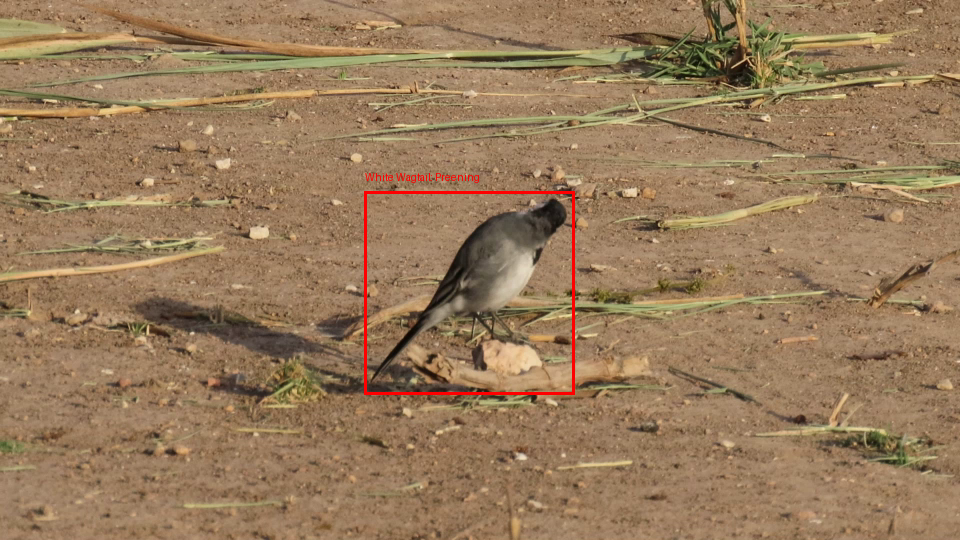

In [13]:
image_with_bbox